# Data Processing for taging/classification task
---

At this notebook you can find additional processing of our data for classification task.

There we clean data with bad tags (tags that indicate that the data is most likely not of interest to us), we clean up tags that do not say anything about the topic,  
and most importantly, we additionally clean text fields from stop words and filter the resulting words through the TF-IDF.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import sys
import os

In [2]:
module_path = os.path.abspath(os.path.join('..')) # Path to root folder
if module_path not in sys.path:
    sys.path.append(module_path + "/scripts") # define scripts path

from ipynb_func import *

Data loader:

In [3]:
NUM = 10 # Number of data parquets to use

assert NUM >= 1 and NUM <= 10, "NUM value must be in range [1, 10]"
#paths = [module_path + f"/data/pikabu/processed/{i}_processed.parquet" for i in range(NUM)] # Making list of roots to merge 
paths = [module_path + f"/data/pikabu/filtered_data/processed_v2/{i}_processed.parquet" for i in range(NUM)] # Making list of roots to merge filtered data

data = merge_dataset(paths)

In [4]:
data = data[data['text_markdown'] != ''] # delete posts without text inside
data = data[['text_markdown', 'tags']] # taking the most interesting parts for our task
print('Data length =', len(data), 'rows')
data.head(5)

Data length = 69192 rows


,text_markdown,tags
7,аня волос нос расти петя аня жопа рассада петя...,Петр;Анна;Рассада;Волосы;Текст;Переписка;Знако...
11,родственница жаловаться дурдом работа трудитьс...,Начальник;Руководитель;Обед;Еда;Сотрудники;Текст
15,добрый сутки господин дама подсказывать назван...,Игры;Мобильное приложение;Гонки;Без рейтинга;П...
23,негр ходить больница читать рэп едит инвалидны...,Ищу песню;Клип;Рэп;Негр;Больница;Текст
28,жук мужик российский ржаной гречневый али выхо...,Родина;Мужики;Текст


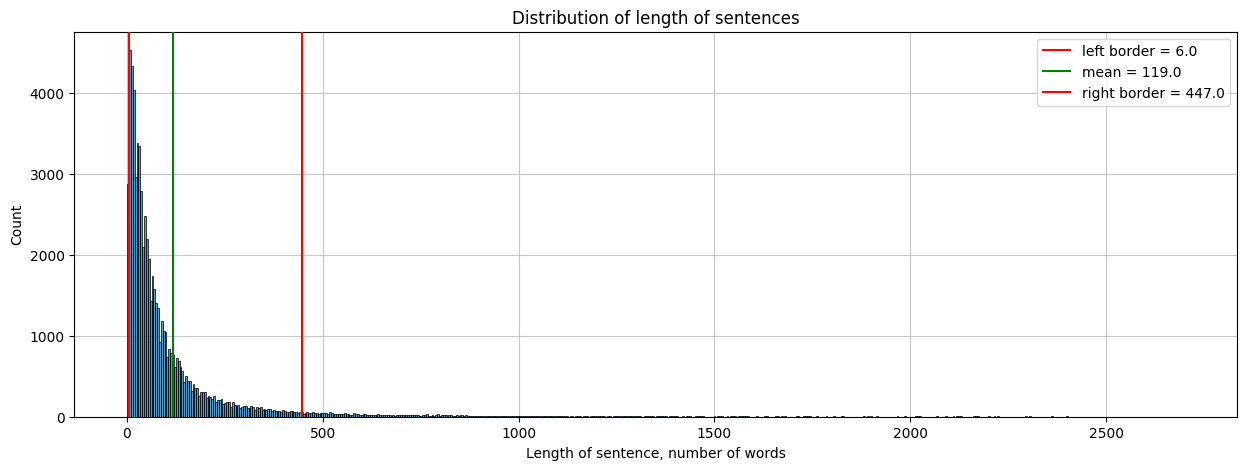

In [5]:
length = list(map(len, [re.split(r' ', t) for t in data.text_markdown]))

alpha = 0.1
left = np.quantile(length, alpha/2)
right = np.quantile(length, 1-alpha/2)
mn = np.mean(length)

f, ax = plt.subplots(figsize=(15, 5))
ax.grid(zorder = 1, alpha=0.7)
ax.axvline(left, c='red', zorder = 10, label=f'left border = {left:.1f}')
ax.axvline(mn, c='green', zorder = 10, label=f'mean = {mn:.1f}')
ax.axvline(right, c='red', zorder = 10, label=f'right border = {right:.1f}')
ax.set_title('Distribution of length of sentences')
ax.legend()
sns.histplot(data = pd.DataFrame(length, columns=['Length of sentence, number of words']), x = 'Length of sentence, number of words', linewidth=.5, zorder = 5);

Using top tags (top topics) from `dataset_tag_analysis.ipynb`:

In [6]:
txt_path = module_path + '/data/top_tags.txt' 
with open(txt_path) as f:
    top_tags = f.readlines()
    top_tags = [word.strip() for word in top_tags]

Let's clean up the tags in the data a bit. So, we will delete posts that contain, in our opinion, those tags that directly indicate the unavailability of using this post as data. We will also remove tags that are not among the top tags according to the data in order to obtain relatively highlighted topics (at least an attempt to do so).

In [7]:
bad_tags = ['Фотография', 'Видео', 'Скриншот', 'Anime Art', 'Гифка', 'Арт', 'Рисунок'] # probably unavailable posts for our task
tags_to_remove = ['Текст', 'Длиннопост', 'Без рейтинга', 'Ответ на пост', 'Комментарии', 'Комментарии на Пикабу', 'Моё', 'Пикабу'] # tags without topic information in top tags

tags_array = formateTags(data)
data.tags = removeTags(tags_array, top_tags, tags_to_remove)
tag_mask = removeEmptyPosts(tags_array)
data = data[tag_mask]
data = removePostsByTags(data, bad_tags)

data.head(5)

,text_markdown,tags
11,родственница жаловаться дурдом работа трудитьс...,[Еда]
15,добрый сутки господин дама подсказывать назван...,[Игры]
37,ехать работа довезти девчонка школа смотреть о...,[Юмор]
52,стадо баранов загон большой стадо гигантский к...,[Мат]
58,помнить хотеть бизнесмен начало нулевой занима...,[Мат]


In [8]:
total_words = ''.join(data.text_markdown)
total_words = re.split(r' ', total_words)
words_dict = getworddict(total_words)

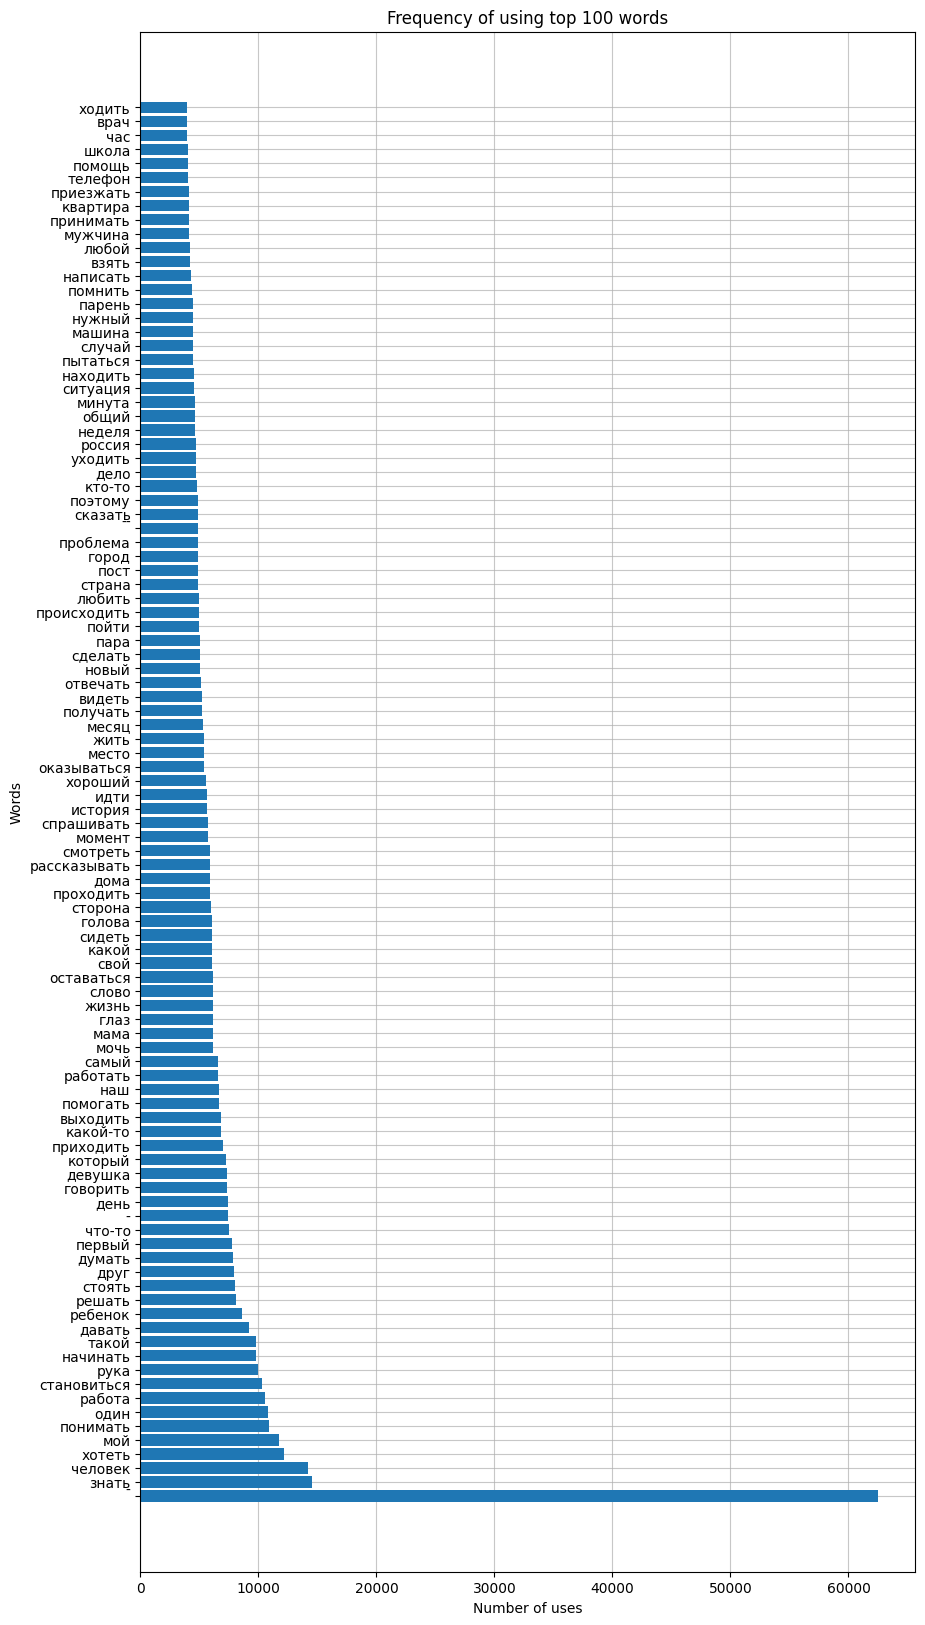

In [9]:
NUM_WORDS = 100
fig, ax = plt.subplots(figsize=(10,20))

word = list(words_dict.keys())
count = list(words_dict.values())

ax.grid(zorder=1, alpha=0.7)
ax.barh(word[0:NUM_WORDS], count[0:NUM_WORDS], zorder=2)
ax.set_title(f"Frequency of using top {NUM_WORDS} words")
ax.set_xlabel("Number of uses")
ax.set_ylabel("Words");

There we begin to clear our data from stopwords. As a great list of stopwords we take txt from this: [github-stopwords-ru](https://github.com/stopwords-iso/stopwords-ru).

In [10]:
#Additional clear for stopwords
txt_path = module_path + '/scripts/stopwords-ru.txt' # github.com/stopwords-iso/stopwords-ru
with open(txt_path, encoding="utf-8") as f:
    rustopwords = f.readlines()
    rustopwords = [word.strip() for word in rustopwords]

additional_stopwords = ['https', '--', '-\n','--\n', '-', 'становиться', 'решать', 'начинать']

final_stopwords = additional_stopwords + rustopwords

We use **TF-IDF** for filtering words. We remove words that occur too often and cannot carry a semantic load, as well as words that occur too rarely,  
because they are outliers (*most likely*), and judging a topic based on one word is not a good thing.

In [11]:
#TF-IDF filtering.

IDF_LEFT_RANGE = 3.
IDF_RIGHT_RANGE = 7.

text_for_idf = [''.join(txt) for txt in data.text_markdown]

tf_idf = TfidfVectorizer(smooth_idf=False)
tf_idf.fit(text_for_idf)
idfs = tf_idf.idf_

idf_mask = (idfs > IDF_LEFT_RANGE) * (idfs < IDF_RIGHT_RANGE)
permitted_words = tf_idf.get_feature_names_out()[idf_mask].tolist()

And by checking words in both lists of `permitted words` and `stopwords`, now we have our *processed data*: 

In [12]:
#final processing of a text
raw_text = [t for t in data.text_markdown]
raw_text = [re.split(r' ', sentance) for sentance in raw_text]
processed_text = [[t for t in words if (t not in final_stopwords) and (t in permitted_words)] for words in raw_text]

data.text_markdown = processed_text # data without stopwords

In [13]:
processed_dct = []
for i in range(len(processed_text)):
    processed_dct.extend(processed_text[i])

processed_dct = getworddict(processed_dct)

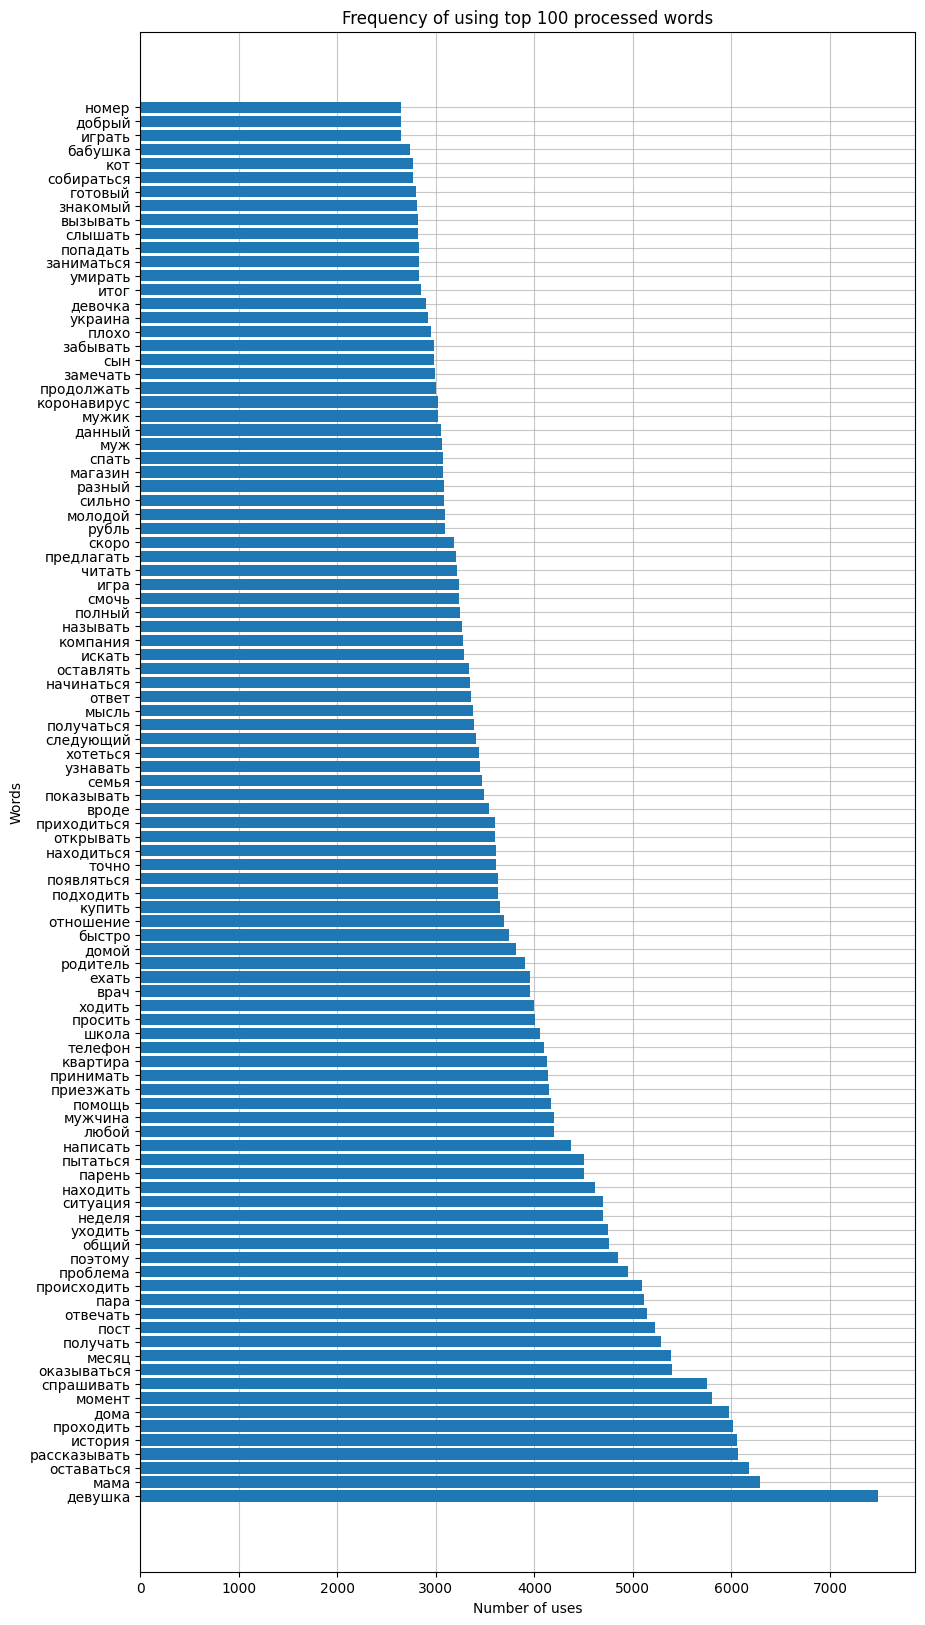

In [14]:
fig, ax = plt.subplots(figsize=(10,20))

word = list(processed_dct.keys())
count = list(processed_dct.values())

ax.grid(zorder=1, alpha=0.7)
ax.barh(word[0:NUM_WORDS], count[0:NUM_WORDS], zorder=2)
ax.set_title(f"Frequency of using top {NUM_WORDS} processed words")
ax.set_xlabel("Number of uses")
ax.set_ylabel("Words");

7.0


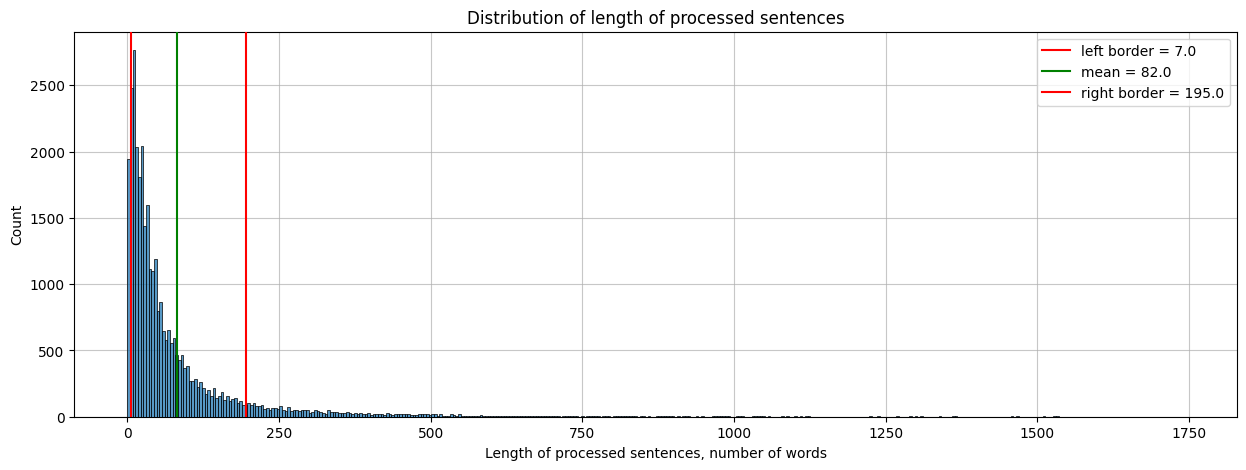

In [15]:
new_length = [len(sentence) for sentence in data.text_markdown]

alpha = 0.2
left = np.quantile(new_length, alpha/2)
right = np.quantile(new_length, 1-alpha/2)
mn = np.mean(new_length)

f, ax = plt.subplots(figsize=(15, 5))
ax.grid(zorder = 1, alpha=0.7)
ax.axvline(left, c='red', zorder = 10, label=f'left border = {left:.1f}')
ax.axvline(mn, c='green', zorder = 10, label=f'mean = {mn:.1f}')
ax.axvline(right, c='red', zorder = 10, label=f'right border = {right:.1f}')
ax.set_title('Distribution of length of processed sentences')
ax.legend()
sns.histplot(data = pd.DataFrame(new_length, columns=['Length of processed sentences, number of words']), x = 'Length of processed sentences, number of words', linewidth=.5, zorder = 5);
print(left)

And now we take posts with length of text at least `NUM_OF_WORDS_IN_POST_AT_LEAST` to prevent posts in data with a few words, that could probably be outliers.

In [16]:
NUM_OF_WORDS_IN_POST_AT_LEAST = 10
assert NUM_OF_WORDS_IN_POST_AT_LEAST >= 1, 'NUM_OF_WORDS_IN_POST must be at least = 1'
text = [texts for texts in data['text_markdown']]
mask = [len(texts) > NUM_OF_WORDS_IN_POST_AT_LEAST for texts in text]

new_data = data
new_data = new_data[mask]

new_data.head(5)

,text_markdown,tags
11,"[жаловаться, трудиться, помощник, руководитель...",[Еда]
15,"[добрый, сутки, господин, дама, подсказывать, ...",[Игры]
37,"[ехать, девчонка, школа, оставаться, свободный...",[Юмор]
52,"[стадо, стадо, гигантский, случаться, стадо, у...",[Мат]
58,"[бизнесмен, начало, нулевой, заниматься, диск,...",[Мат]


Saving processed data in a parquet file for future use:

In [18]:
a = input('Are you sure, that you want to save the parquet? (Y/n)')
if a == 'Y':
    #save_path = module_path + '/data/pikabu/tag_processed/raw_data/' # for raw data
    save_path = module_path + '/data/pikabu/tag_processed/filtered_data/' # for filtered data
    new_data.to_parquet(save_path + '0_tag_processed.parquet')